# **Segmentez des clients d'un site e-commerce** 
## partie 3/4 : simulation pour déterminer la fréquence nécessaire de mise à jour du modèle

### <br> Résumé des épisodes précédents :

> &emsp; "Nous avons notre segmentation, il s'agit maintenant de tester sa stabilité dans le temps."<br><br>

## 1 Importation des librairies, réglages

In [16]:
import sys
import numpy as np
import pandas as pd
import random
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score


print('Python version ' + sys.version)  # Print Python version
print('\npandas version ' + pd.__version__)
print('sns version ' + sns.__version__)

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
sns.set(font_scale=1)


Python version 3.11.4 (main, Jul  5 2023, 14:15:25) [GCC 11.2.0]

pandas version 2.1.1
sns version 0.12.2


## Fonctions

In [17]:
def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values, 
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    missing = df.isna().sum()
    percent_missing = df.isna().mean()*100
    missings_df = pd.DataFrame({'column_name': df.columns,
                                     'missing': missing,
                                     'present' : df.shape[0] - missing,
                                     'percent_missing': percent_missing.round(2),
                                     'type': df.dtypes})
    missings_df.sort_values('missing', inplace=True)
    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


## Import data

In [18]:
rfms_complet = pd.read_csv('data/rfms.csv', sep=',')

rfms_complet['datetime'] = pd.to_datetime(rfms_complet['datetime'])

rfms = rfms_complet.loc[rfms_complet['satisfaction'].notna(), :].copy()

quick_look(rfms, True)

# Rappel : 2 features skewed déjà passées au log(x+1)
# Pas encore scaled


shape : (94457, 5)


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime
0,9716613.0,0.693147,4.962145,5.0,2018-05-10 10:56:27
1,9974913.0,0.693147,3.338967,4.0,2018-05-07 11:11:27
2,46486497.0,0.693147,4.468434,3.0,2017-03-10 21:05:03
3,27826219.0,0.693147,3.798182,4.0,2017-10-12 20:29:41
4,24977658.0,0.693147,5.287711,5.0,2017-11-14 19:45:42


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime
95150,38710764.0,0.693147,7.634540,5.0,2017-06-08 21:00:36
95151,22729924.0,0.693147,4.449452,4.0,2017-12-10 20:07:56
95152,49183844.0,0.693147,4.731450,5.0,2017-02-07 15:49:16
95153,10392139.0,0.693147,4.902976,5.0,2018-05-02 15:17:41
95154,41910075.0,0.693147,4.284414,5.0,2017-05-02 20:18:45


uniques :


recent_timestamp    94204
nb_commandes            9
payment_total       27926
satisfaction           34
datetime            94204
dtype: int64

Doublons ?  1 



,column_name,missing,present,percent_missing,type
recent_timestamp,recent_timestamp,0,94457,0.0,float64
nb_commandes,nb_commandes,0,94457,0.0,float64
payment_total,payment_total,0,94457,0.0,float64
satisfaction,satisfaction,0,94457,0.0,float64
datetime,datetime,0,94457,0.0,datetime64[ns]


In [19]:
rfms['year_week'] = rfms['datetime'].map(lambda dt: dt.strftime('%Y-%U'))
quick_look(rfms)


shape : (94457, 6)


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week
0,9716613.0,0.693147,4.962145,5.0,2018-05-10 10:56:27,2018-18
1,9974913.0,0.693147,3.338967,4.0,2018-05-07 11:11:27,2018-18
2,46486497.0,0.693147,4.468434,3.0,2017-03-10 21:05:03,2017-10
3,27826219.0,0.693147,3.798182,4.0,2017-10-12 20:29:41,2017-41
4,24977658.0,0.693147,5.287711,5.0,2017-11-14 19:45:42,2017-46


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week
95150,38710764.0,0.693147,7.634540,5.0,2017-06-08 21:00:36,2017-23
95151,22729924.0,0.693147,4.449452,4.0,2017-12-10 20:07:56,2017-50
95152,49183844.0,0.693147,4.731450,5.0,2017-02-07 15:49:16,2017-06
95153,10392139.0,0.693147,4.902976,5.0,2018-05-02 15:17:41,2018-17
95154,41910075.0,0.693147,4.284414,5.0,2017-05-02 20:18:45,2017-18


uniques :


recent_timestamp    94204
nb_commandes            9
payment_total       27926
satisfaction           34
datetime            94204
year_week              91
dtype: int64

Doublons ?  1 



,column_name,missing,present,percent_missing,type
recent_timestamp,recent_timestamp,0,94457,0.0,float64
nb_commandes,nb_commandes,0,94457,0.0,float64
payment_total,payment_total,0,94457,0.0,float64
satisfaction,satisfaction,0,94457,0.0,float64
datetime,datetime,0,94457,0.0,datetime64[ns]
year_week,year_week,0,94457,0.0,object


## 2 Période d'entrainement du modèle : vérifications

2016-36
2018-34


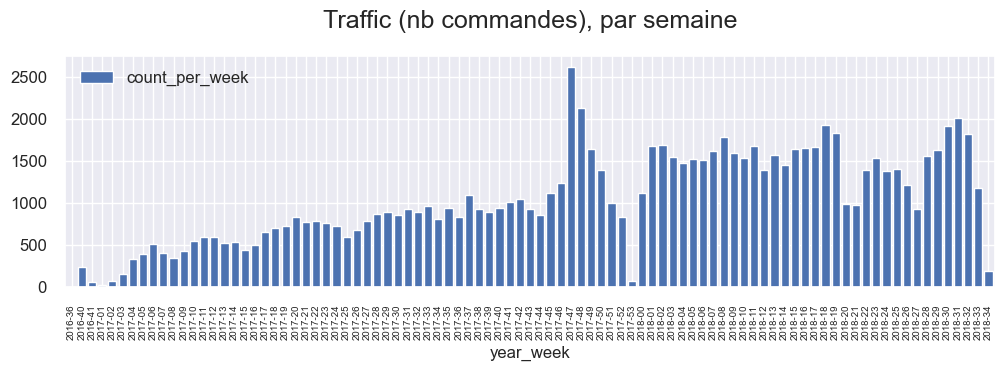

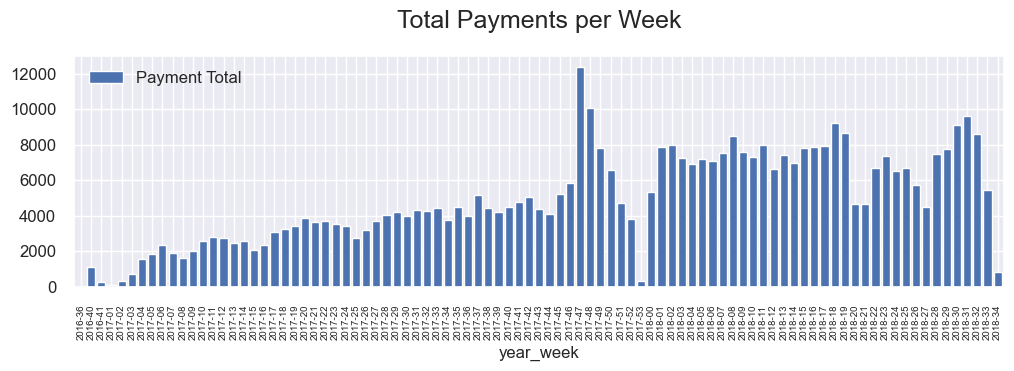

In [20]:
print(rfms['year_week'].min())
print(rfms['year_week'].max())

# Rappel (notebook 1)

grouped_week = rfms.groupby('year_week').size().to_frame("count_per_week").reset_index()

fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figsize as needed

grouped_week.plot(kind='bar', x='year_week', y='count_per_week', fontsize=12, ax=ax, width=0.8)
plt.title('Traffic (nb commandes), par semaine', fontsize=18, pad=20)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(fontsize=7)
plt.show()

grouped_week_payment = rfms.groupby('year_week')['payment_total'].sum().reset_index()

fig1, ax1 = plt.subplots(figsize=(12, 3))  # Adjust the figsize as needed

grouped_week_payment.plot(kind='bar', x='year_week', y='payment_total', fontsize=12, ax=ax1, width=0.8)
plt.title('Total Payments per Week', fontsize=18, pad=20)
plt.legend(['Payment Total'], loc='upper left', fontsize=12)
plt.xticks(fontsize=7)
plt.show()

# Je pensais que les graphs seraient similaires car le panier moyen est stable et il y a bcp de commandes.
# Pour le coup, c'est similaire !


(1766, 6)
2017-02-11


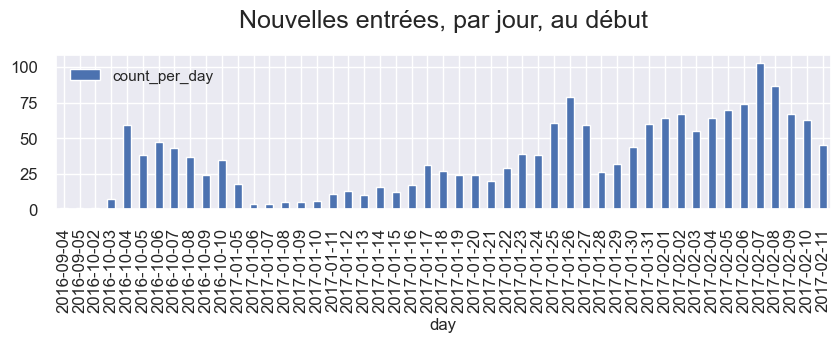

In [21]:
# Early days

early = rfms.loc[(rfms['year_week'] <= '2017-06'), :].copy()
print(early.shape)

# par jour
early['day'] = early['datetime'].map(lambda dt: dt.strftime('%Y-%m-%d'))
print(early['day'].max())

grouped_early = early.groupby('day').size().to_frame("count_per_day").reset_index()
grouped_early = grouped_early.sort_values('day')

fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the figsize as needed

grouped_early.plot(kind='bar', x='day', y='count_per_day', fontsize=12, ax=ax)
plt.title('Nouvelles entrées, par jour, au début', fontsize=18, pad=20)
plt.show()

# Enlever jusqu'à troisième semaine de janvier 2017 incluse.


In [22]:
# D'après les données ci-dessus, 3 périodes ont des activités inhabituelles. 
# Il s'agit de :

# - la période du début (2016 - trois premières semaines de janvier 2017 incluses)
# car il y a un trou ds le dataset. Ils ont peut-être fait des tests de lancement.

# - la période autour de Noel 2017 (semaines 47-53, + semaine 0 2018 ?)
# Assez logique d'avoir un pic de dépenses juste avant Noel... Et le creu qui suit s'explique aussi :
# Tt le monde est fauché après avoir gâté les mômes.
# Bcp d'entreprises font leur maintenance serveur à cette époque.

# - 2018, après la derniere semaine d'août, incluse (semaines >= 34 out)
# Là je n'ai pas d'hypothèse, mais on constate un effondrement de la quantité de data en fin de période,
# qui contraste fortement avec l'activité des 2 années précédentes.

# Pour entrainer et tester notre modèle, on va donc utiliser la data de 2018, semaines 4 à 33
data_simul = rfms.loc[(rfms['year_week'] > '2018-03')
                & (rfms['year_week'] < '2018-34'), :].copy()

quick_look(data_simul)
data_simul.describe()

# Il nous reste environ la moitié des données.


shape : (45850, 6)


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week
0,9716613.0,0.693147,4.962145,5.0,2018-05-10 10:56:27,2018-18
1,9974913.0,0.693147,3.338967,4.0,2018-05-07 11:11:27,2018-18
5,12709604.0,0.693147,5.123845,4.0,2018-04-05 19:33:16,2018-13
6,11437357.0,0.693147,3.594019,4.0,2018-04-20 12:57:23,2018-15
7,15849859.0,0.693147,6.040683,1.0,2018-02-28 11:15:41,2018-08


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week
95141,3571950.0,0.693147,4.424966,5.0,2018-07-20 13:47:30,2018-28
95142,5116801.0,0.693147,7.953656,5.0,2018-07-02 16:39:59,2018-26
95145,1337583.0,0.693147,4.165424,4.0,2018-08-15 10:26:57,2018-32
95149,12259528.0,0.693147,6.567656,1.0,2018-04-11 00:34:32,2018-14
95153,10392139.0,0.693147,4.902976,5.0,2018-05-02 15:17:41,2018-17


uniques :


recent_timestamp    45693
nb_commandes            9
payment_total       19071
satisfaction           31
datetime            45693
year_week              30
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
recent_timestamp,recent_timestamp,0,45850,0.0,float64
nb_commandes,nb_commandes,0,45850,0.0,float64
payment_total,payment_total,0,45850,0.0,float64
satisfaction,satisfaction,0,45850,0.0,float64
datetime,datetime,0,45850,0.0,datetime64[ns]
year_week,year_week,0,45850,0.0,object


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime
count,4.585000e+04,45850.000000,45850.000000,45850.000000,45850
mean,9.565796e+06,0.708012,4.741538,4.102038,2018-05-12 04:50:04.350774272
min,4.260520e+05,0.693147,2.359910,1.000000,2018-01-28 00:07:44
25%,4.886698e+06,0.693147,4.163093,4.000000,2018-03-19 18:34:30.750000128
50%,9.856946e+06,0.693147,4.713666,5.000000,2018-05-08 19:57:34
75%,1.418193e+07,0.693147,5.227788,5.000000,2018-07-05 08:35:01.750000128
max,1.856834e+07,2.833213,8.892320,5.000000,2018-08-25 23:39:08
std,5.301032e+06,0.083149,0.813420,1.336176,NaN


## 3 Scaling

In [23]:
# Tout scale ici, avant de slicer
# (mm scaler pour tte la data, sinon l'entrainement du kmeans n'aurait plus aucun sens
# sur une data scaled séparément, donc différemment)

features_RFMS = ['recent_timestamp', 'nb_commandes', 'payment_total', 'satisfaction']

scaler = StandardScaler()

data = data_simul.copy()

data[features_RFMS] = scaler.fit_transform(data[features_RFMS])


## 4 Slicing (par semaine)

In [24]:
week = []

unique_values = np.sort(data['year_week'].unique())
print(len(unique_values))
print(unique_values)

for i, semaine in enumerate(unique_values):
    week.append(data.loc[data['year_week'] <= semaine, :].copy())
    print(week[i].shape[0])


30
['2018-04' '2018-05' '2018-06' '2018-07' '2018-08' '2018-09' '2018-10'
 '2018-11' '2018-12' '2018-13' '2018-14' '2018-15' '2018-16' '2018-17'
 '2018-18' '2018-19' '2018-20' '2018-21' '2018-22' '2018-23' '2018-24'
 '2018-25' '2018-26' '2018-27' '2018-28' '2018-29' '2018-30' '2018-31'
 '2018-32' '2018-33']
1480
3007
4520
6139
7931
9524
11060
12743
14140
15707
17160
18801
20453
22120
24051
25881
26868
27838
29236
30771
32151
33557
34770
35701
37267
38901
40824
42844
44670
45850


## 5 k-means de référence, premier test

In [25]:
# ensuite on entraine un premier kmeans sur la premiere semaine.

# Assuming 5 is the optimal number of clusters
def assign_labels_using_kmeans(df, features=features_RFMS, best_k=5, silhouette=False): 
        kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
        kmeans.fit(df[features])

        if silhouette == True:
            print('silhouette_score = ', silhouette_score(df[features], kmeans.labels_))

        return kmeans, kmeans.labels_

kmeans_0, labels_kmeans_0_t0 = assign_labels_using_kmeans(df=week[0], silhouette=True)

labels_kmeans_0_t1 = kmeans_0.predict(week[1][features_RFMS])

kmeans_1, labels_kmeans_1_t1 = assign_labels_using_kmeans(df=week[1], silhouette=True)

ari = adjusted_rand_score(labels_kmeans_0_t1, labels_kmeans_1_t1)

print(f'ARI = {ari}', '\n')


silhouette_score =  0.4332880342144427


silhouette_score =  0.4141653663171143
ARI = 0.8283739777619658 



In [26]:
# ARI déjà limite (proche 0.8)
# Peut-être qu'une semaine d'entrainement, ce n'est pas assez ?
# Peut-être qu'une semaine d'interval, c un peu trop ?

data['day'] = data['datetime'].map(lambda dt: dt.strftime('%Y-%m-%d'))

day = []

unique_values = np.sort(data['day'].unique())
print(len(unique_values))
# print(unique_values)

for i, jour in enumerate(unique_values):
    day.append(data.loc[data['day'] <= jour, :].copy())
    # print(day[i].shape[0])

quick_look(data)


210
shape : (45850, 7)


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week,day
0,0.028451,-0.178779,0.271212,0.672046,2018-05-10 10:56:27,2018-18,2018-05-10
1,0.077178,-0.178779,-1.724307,-0.076366,2018-05-07 11:11:27,2018-18,2018-05-07
5,0.593062,-0.178779,0.470005,-0.076366,2018-04-05 19:33:16,2018-13,2018-04-05
6,0.353060,-0.178779,-1.410749,-0.076366,2018-04-20 12:57:23,2018-15,2018-04-20
7,1.185454,-0.178779,1.597157,-2.321605,2018-02-28 11:15:41,2018-08,2018-02-28


,recent_timestamp,nb_commandes,payment_total,satisfaction,datetime,year_week,day
95141,-1.130706,-0.178779,-0.389190,0.672046,2018-07-20 13:47:30,2018-28,2018-07-20
95142,-0.839279,-0.178779,3.948948,0.672046,2018-07-02 16:39:59,2018-26,2018-07-02
95145,-1.552208,-0.178779,-0.708269,-0.076366,2018-08-15 10:26:57,2018-32,2018-08-15
95149,0.508158,-0.178779,2.245013,-2.321605,2018-04-11 00:34:32,2018-14,2018-04-11
95153,0.155885,-0.178779,0.198470,0.672046,2018-05-02 15:17:41,2018-17,2018-05-02


uniques :


recent_timestamp    45693
nb_commandes            9
payment_total       19071
satisfaction           31
datetime            45693
year_week              30
day                   210
dtype: int64

Doublons ?  0 



,column_name,missing,present,percent_missing,type
recent_timestamp,recent_timestamp,0,45850,0.0,float64
nb_commandes,nb_commandes,0,45850,0.0,float64
payment_total,payment_total,0,45850,0.0,float64
satisfaction,satisfaction,0,45850,0.0,float64
datetime,datetime,0,45850,0.0,datetime64[ns]
year_week,year_week,0,45850,0.0,object
day,day,0,45850,0.0,object


## 6 Mesure + précise (sur une semaine de data)

[1.0, 0.4767746538307782, 0.995034786705967, 0.8480563204246014, 0.8478011825578562, 0.4915299790435634, 0.9944767829704079, 0.8283739777619658, 0.9966733365734215, 0.8520117887655596, 0.5031550914547191, 0.5961791149433624, 0.9147272635297204, 0.5055445397298475, 0.5733975553230043, 0.5018492873765137, 0.5749580370483075, 0.48293456745001156, 0.42494938356953826, 0.5729687212295551, 0.4875399630367108, 0.42181383889334567, 0.9154213085461168, 0.9704179900181721, 0.4300056420144684, 0.5492277179389367, 0.8382877613959814, 0.5569844493940173, 0.8376374679025278, 0.5452964295749011, 0.8383239462715204, 0.5348600702891216, 0.5466224276695619, 0.5357714493676377, 0.5270924679138725, 0.526052582625903, 0.5440091159411528, 0.494389757496234, 0.49165539542899717, 0.5525179567755565, 0.5326367356122667, 0.7352990832697847, 0.48685162700316087, 0.8382560987854665, 0.48408449303222023, 0.5294698864147172, 0.4863602072356503, 0.5329819026813792, 0.511286178493788, 0.5134423231096965, 0.4768791306

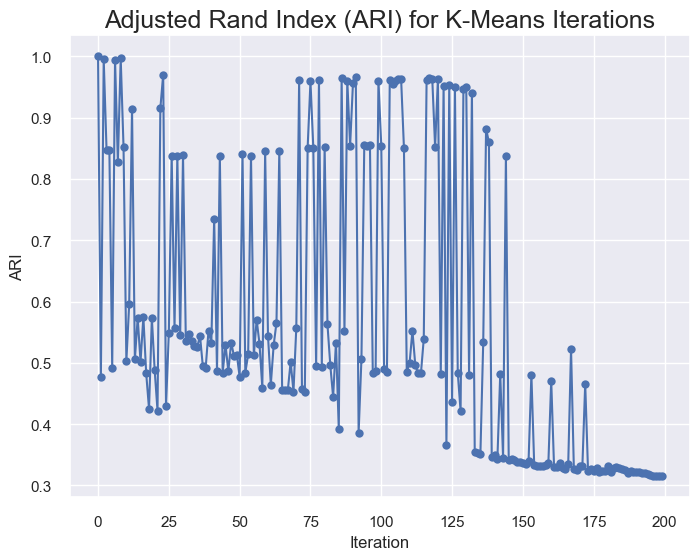

In [27]:
# On a déjà notre kmeans de reference, kmeans_0

kmeans = []
labels_kmeans_t_t = []
labels_kmeans_0_t = []
aris = []

max_iter = 200

for i in range(0, max_iter):
    km, labels = assign_labels_using_kmeans(df=day[6+i])
    kmeans.append(km)
    labels_kmeans_t_t.append(labels)

    labels_kmeans_0_t.append(kmeans_0.predict(day[6+i][features_RFMS]))

    aris.append(adjusted_rand_score(labels_kmeans_0_t[i], labels_kmeans_t_t[i]))

print(aris)

iterations = list(range(0, max_iter))

# Create a line plot of ARI values
plt.figure(figsize=(8, 6))
plt.plot(iterations, aris, marker='o', linestyle='-')
plt.title('Adjusted Rand Index (ARI) for K-Means Iterations', fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('ARI', fontsize=12)
plt.grid(True)
plt.show()

# La premiere valeur est bien == 1

# Et moi qui imaginais que ça allait descendre régulièrement...
# Un jour c'est bien trop peu de data

# Il faut lisser,
# éradiquer les tentacules de la déréliction. Et tout deviendra clair.
# Mais comment faire ? Je prends la valeur moyenne ??
# Une période + large ?
# J'ignore de le savoir.


## 7 Période d'entrainement + longue (1 mois)

6139
220


silhouette_score =  0.40617798073863925
[1.0, 0.41778845361902106, 0.4346144892404656, 0.9964563338542541, 0.603789471873107, 0.4491779840685016, 0.6724577303952007, 0.4523638161515361, 0.6030186758885951, 0.4587738388086792, 0.609739469255397, 0.6942281995501712, 0.6105050245637086, 0.6184920743245682, 0.6180867933572315, 0.7045341354179852, 0.8102662984872675, 0.8147099032499301, 0.595461583814332, 0.7098966991082739, 0.5218954072404968, 0.819386966395521, 0.46658037341146863, 0.8230091550519236, 0.7100659545405994, 0.8141395155395483, 0.6106503139830626, 0.6286872653486734, 0.627564443861593, 0.8281965582128082]


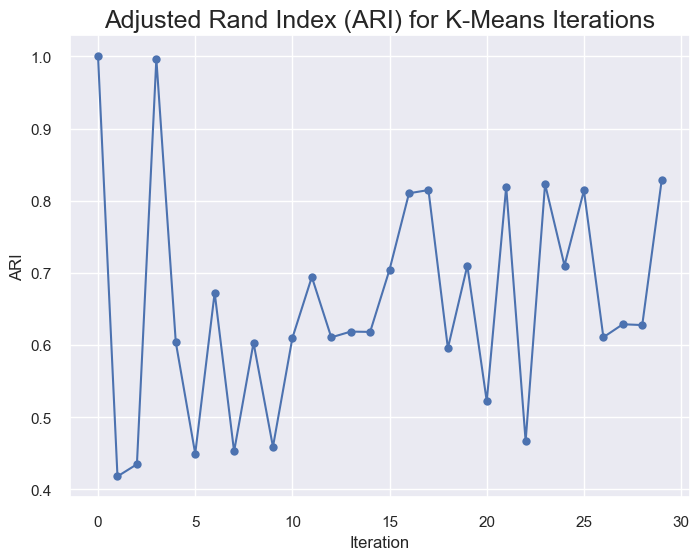

In [28]:
# On va prendre comme nvelle ref un kmeans entrainé pdt un mois cette fois-ci
print(day[27].shape[0])
print(day[28].shape[0] - day[27].shape[0])

kmeans_0, labels_kmeans_0_t0 = assign_labels_using_kmeans(df=day[27], silhouette=True)

aris = []
kmeans = []
labels_kmeans_t_t = []
labels_kmeans_0_t = []

max_iter = 30

for i in range(0, max_iter):
    km, labels = assign_labels_using_kmeans(df=day[27+i])
    kmeans.append(km)
    labels_kmeans_t_t.append(labels)

    labels_kmeans_0_t.append(kmeans_0.predict(day[27+i][features_RFMS]))

    aris.append(adjusted_rand_score(labels_kmeans_0_t[i], labels_kmeans_t_t[i]))

print(aris)

iterations = list(range(0, max_iter))

# Create a line plot of ARI values
plt.figure(figsize=(8, 6))
plt.plot(iterations, aris, marker='o', linestyle='-')
plt.title('Adjusted Rand Index (ARI) for K-Means Iterations', fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('ARI', fontsize=12)
plt.grid(True)
plt.show()

# La premiere valeur est bien == 1

# Pas mieux
# Je prends la valeur moyenne ??


## encore + longue (3 mois)

20453
20620


silhouette_score =  0.3442082432960883
[1.0, 0.5428697282305395, 0.552029590551633, 0.7218727146609735, 0.5533786354584266, 0.5442575962146362, 0.552891164532638, 0.5435833937185326, 0.5376282465739812, 0.7245853090561876, 0.5395558384485518, 0.5361744704631173, 0.5395513133528002, 0.6403951750284147, 0.643153053112906, 0.5416592182505218, 0.540717252125023, 0.6472229262708509, 0.6425283482153238, 0.5400177287547117, 0.5467372650806629, 0.5408715571725594, 0.5392232897791415, 0.5386702467992767, 0.5383651504535947, 0.6425319074780542, 0.7166697424896898, 0.7223541459196158, 0.7130382786418848, 0.6405706681411607, 0.6415151383667758, 0.7042660127723874, 0.538220018678487, 0.5327958150022625, 0.5335398066045028, 0.5373142059177304, 0.5320682977627798, 0.6393763741089178, 0.5420108652817416, 0.43765338379640517, 0.5351421439905385, 0.5967087376915298, 0.5391451609776823, 0.6425480551924804, 0.6228563682011492, 0.5404357556932833, 0.5347958973994751, 0.6381431297579063, 0.5411904124352214,

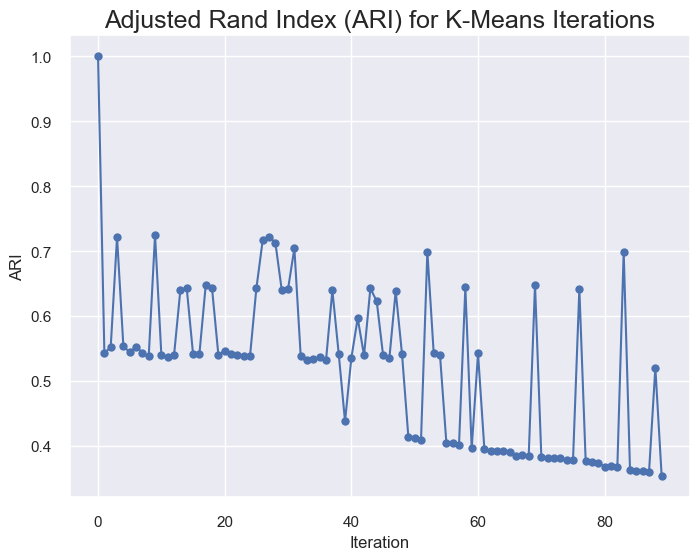

In [29]:
# 3 mois ??
print(day[90].shape[0])
print(day[91].shape[0])

kmeans_0, labels_kmeans_0_t0 = assign_labels_using_kmeans(df=day[90], silhouette=True)

aris = []
kmeans = []
labels_kmeans_t_t = []
labels_kmeans_0_t = []

max_iter = 90

for i in range(0, max_iter):
    km, labels = assign_labels_using_kmeans(df=day[90+i])
    kmeans.append(km)
    labels_kmeans_t_t.append(labels)

    labels_kmeans_0_t.append(kmeans_0.predict(day[90+i][features_RFMS]))

    aris.append(adjusted_rand_score(labels_kmeans_0_t[i], labels_kmeans_t_t[i]))

print(aris)

iterations = list(range(0, max_iter))

# Create a line plot of ARI values
plt.figure(figsize=(8, 6))
plt.plot(iterations, aris, marker='o', linestyle='-')
plt.title('Adjusted Rand Index (ARI) for K-Means Iterations', fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('ARI', fontsize=12)
plt.grid(True)
plt.show()

# La premiere valeur est bien == 1

# Pas mieux
# Je prends la valeur moyenne ??


## Conclusion

44227
44476
210
silhouette_score =  0.312970849311624
[1.0, 0.9303216450039092, 0.9685052446462346, 0.9284446143247749, 0.9521188497854677, 0.948637111160912, 0.88011727719438, 0.910673235363796, 0.8809749088126398, 0.8524919876921758, 0.8432919211826119, 0.8356157415932817, 0.8261330575006498, 0.8464421270780407, 0.8109313772017009, 0.8074636941708896, 0.8059455207568309, 0.8108127294017884, 0.800855564093372, 0.7919269496540813, 0.7832780689384599, 0.785766629491834, 0.7831668493103792, 0.780422913363407, 0.7639618691455522]


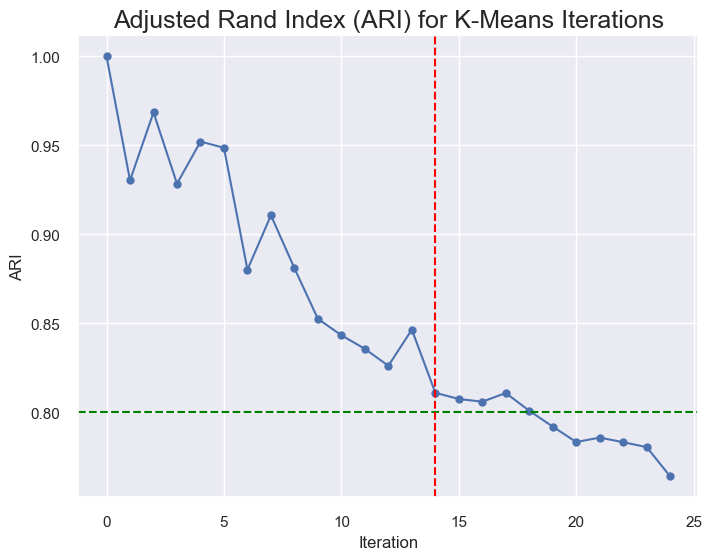

In [32]:
# 6 mois 

print(day[200].shape[0])
print(day[201].shape[0])
print(len(day))

kmeans_0, labels_kmeans_0_t0 = assign_labels_using_kmeans(df=day[180], silhouette=True)

aris = []
kmeans = []
labels_kmeans_t_t = []
labels_kmeans_0_t = []

max_iter = 25

for i in range(0, max_iter):
    km, labels = assign_labels_using_kmeans(df=day[180+i])
    kmeans.append(km)
    labels_kmeans_t_t.append(labels)

    labels_kmeans_0_t.append(kmeans_0.predict(day[180+i][features_RFMS]))

    aris.append(adjusted_rand_score(labels_kmeans_0_t[i], labels_kmeans_t_t[i]))

print(aris)

iterations = list(range(0, max_iter))

# Create a line plot of ARI values
plt.figure(figsize=(8, 6))
plt.plot(iterations, aris, marker='o', linestyle='-')
plt.axhline(y=0.8, color='green', linestyle='--', label='Threshold') 
plt.axvline(x=14, color='red', linestyle='--', label='Threshold') 
plt.title('Adjusted Rand Index (ARI) for K-Means Iterations', fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('ARI', fontsize=12)
plt.grid(True)
plt.show()

# La premiere valeur est bien == 1

# Enfin !
# Donc ct pas un bug, juste qu'il faut vraiment bcp de data pour que des formes stables apparaissent en 4D.

# Normalement ils sont tranquilles 14 jours, deux semaines 
# (on a une petite marge de sécurité). 

# On peut sans doute améliorer encore un peu en étendant la période,
# mais il faut aussi privilégier la data plus récente,
# donc ceci me parait un bon compromis. 

# Merci d'avoir lu jusqu'ici :)
